## Прогноз покупательской активности клиентов интернет-магазина «В один клик»

## Ссылка на репозиторий
[GitHub Project](https://github.com/Rozyyev23/supervised-learning-project)

### Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Продумывать подход к решению этой задачи вам не придётся — руководитель отдела его уже сформировал:

- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
- Нужно собрать данные по клиентам по следующим группам:
  - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
  - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
  - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
  - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Загрузка данных

In [ ]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

In [ ]:
!pip install phik shap -q

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import phik
import shap
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# кодирование и масштабирование
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# метрики
from sklearn.metrics import roc_auc_score

# подбор гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
def display_basic_info(df, count=5):
    display(df.head(count))
    display(df.info())


def display_box(col, ax):
    col.plot(kind='box', vert=False, medianprops={'color': 'red'}, ax=ax)
    ax.set_title(f'Диаграмма размаха признака\n«{col.name}»')
    ax.set_xlabel(col.name)
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.5, linestyle=':')


def display_hist(data, x_col_name, ax, hue=None):
    sns.histplot(data, x=x_col_name, hue=hue,
                 discrete=pd.api.types.is_integer_dtype(data[x_col_name].dtype),
                 kde=True, kde_kws={'bw_method': 0.6}, edgecolor='white', ax=ax)
    ax.set_title(f'Распределение признака\n«{x_col_name}»')
    ax.set_xlabel(x_col_name)
    ax.set_ylabel('Количество')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def display_barh(col, ax):
    grouped_data = col.value_counts(normalize=True) * 100
    grouped_data.plot(kind='barh', color='#8ebad9', ax=ax)
    # Цикл для добавления меток
    for i, bar in enumerate(ax.patches):
        # Получаем ширину и координаты каждого столбца
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2

        # 1. Добавляем метку с процентами ВНУТРИ столбца (аналог label_type='center')
        ax.text(
            x=width / 2,          # Позиция X: середина столбца
            y=y_pos,              # Позиция Y: центр столбца по вертикали
            s=f'{width:.2f}%',    # Текст: значение с форматированием
            ha='center',          # Горизонтальное выравнивание
            va='center',          # Вертикальное выравнивание
            color='white',        # Цвет текста для лучшей читаемости
            fontweight='bold'
        )

        # 2. Добавляем метку с названием категории СНАРУЖИ столбца (аналог padding)
        ax.text(
            x=width + 0.5,        # Позиция X: конец столбца + небольшой отступ
            y=y_pos,              # Позиция Y: та же
            s=grouped_data.index[i], # Текст: название категории из индекса
            ha='left',            # Выравнивание по левому краю
            va='center'           # Выравнивание по центру
        )
    ax.set_title(f'Распределение признака\n«{col.name}»')
    ax.set_xlabel('Доля, %')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def display_corr_matrix_heatmap(corr_coefficients, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    sns.heatmap(corr_coefficients, annot=True, square=True, cbar=True, cbar_kws={'shrink': 0.8},
                linewidths=0.5, cmap='Greens', ax=ax)
    ax.set_title(title)
    plt.show()

In [ ]:
RANDOM_STATE = 42

Считаем CSV-файлы с данными и сохраним их в датафреймы. Изучим общую информацию о датафреймах.

In [ ]:
customers = pd.read_csv('/datasets/market_file.csv')
display_basic_info(customers)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

In [ ]:
customer_costs = pd.read_csv('/datasets/market_money.csv')
display_basic_info(customer_costs)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

In [ ]:
customer_time = pd.read_csv('/datasets/market_time.csv')
display_basic_info(customer_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

In [ ]:
market_profit = pd.read_csv('/datasets/money.csv', decimal=',', sep=';')
display_basic_info(market_profit)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

## Предобработка данных

### Покупатели

In [ ]:
customers.columns = ['id', 'активность', 'тип_сервиса', 'сообщения_разрешены',
                     'маркет_актив_средн', 'маркет_актив_тек_мес', 'длительность',
                     'акционные_покупки', 'популярная_категория', 'категорий_за_визит',
                     'неоплаченная_корзина', 'ошибки', 'страниц_за_визит']

In [ ]:
customers.duplicated(subset='id').sum()

0

Явных дубликатов в датафрейме нет.

In [ ]:
customers.isna().sum().sum()

0

Пропусков не обнаружено.

Посмотрим на уникальные значения в столбце тип_сервиса.

In [ ]:
customers['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Значения «стандартт» и «стандарт» явно означают одно и то же. Объединим их.

In [ ]:
customers['тип_сервиса'] = customers['тип_сервиса'].str.replace('стандартт', 'стандарт')

Посмотрим на результат.

In [ ]:
display_basic_info(customers)

,id,активность,тип_сервиса,сообщения_разрешены,маркет_актив_средн,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,категорий_за_визит,неоплаченная_корзина,ошибки,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1300 non-null   int64  
 1   активность            1300 non-null   object 
 2   тип_сервиса           1300 non-null   object 
 3   сообщения_разрешены   1300 non-null   object 
 4   маркет_актив_средн    1300 non-null   float64
 5   маркет_актив_тек_мес  1300 non-null   int64  
 6   длительность          1300 non-null   int64  
 7   акционные_покупки     1300 non-null   float64
 8   популярная_категория  1300 non-null   object 
 9   категорий_за_визит    1300 non-null   int64  
 10  неоплаченная_корзина  1300 non-null   int64  
 11  ошибки                1300 non-null   int64  
 12  страниц_за_визит      1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


None

Датафрейм customers содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- id — номер покупателя в корпоративной базе данных.
- активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- тип_сервиса — уровень сервиса, например «премиум» и «стандарт».
- сообщения — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- маркет_актив_средн — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- длительность — сколько дней прошло с момента регистрации покупателя на сайте.
- акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- неоплаченная_корзина — общее число неоплаченных товаров в корзине за последние 3 месяца.
- ошибки — число сбоев, которые коснулись покупателя во время посещения сайта.
- страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

### Покупки

Заменим названия столбцов в датафрейме customer_costs.

In [ ]:
customer_costs.columns = ['id', 'период', 'выручка']

In [ ]:
customer_costs.duplicated(subset=['id', 'период']).sum()

0

Явных дубликатов в датафрейме нет.

In [ ]:
customer_costs.isna().sum().sum()

0

Пропусков не обнаружено.

In [ ]:
display_basic_info(customer_costs)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

Датафрейм `customer_costs` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

- id — номер покупателя в корпоративной базе данных.
- период — название периода, во время которого зафиксирована выручка.
- выручка — сумма выручки за период.

### Время на сайте

Заменим названия столбцов в датафрейме customer_time.

In [ ]:
customer_time.columns = ['id', 'период', 'время_на_сайте']

In [ ]:
customer_time.duplicated(subset=['id', 'период']).sum()

0

Явных дубликатов в датафрейме нет.

In [ ]:
customer_time.isna().sum().sum()

0

Пропусков не обнаружено.

Посмотрим на уникальные значения в столбце период.

In [ ]:
customer_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [ ]:
customer_time['период'] = customer_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [ ]:
display_basic_info(customer_time)

,id,период,время_на_сайте
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2600 non-null   int64 
 1   период          2600 non-null   object
 2   время_на_сайте  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

Датафрейм customer_time содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

- id — номер покупателя в корпоративной базе данных.
- период — название периода, во время которого зафиксировано общее время.
- время_на_сайте — значение времени, проведённого на сайте, в минутах.

### Прибыль

In [ ]:
market_profit.columns = ['id', 'прибыль']

In [ ]:
market_profit.duplicated(subset='id').sum()

0

Явных дубликатов в датафрейме нет.

In [ ]:
market_profit.isna().sum().sum()

0

Пропусков не обнаружено.

Посмотрим на результат.

In [ ]:
display_basic_info(market_profit)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

Датафрейм market_profit содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:

- id — номер покупателя в корпоративной базе данных.
- прибыль — среднемесячная прибыль, которую получает магазин от продаж покупателю.

### Результаты предобработки

В результате предобработки данных:

- Скорректированы названия столбцов в датафреймах.
- Явных дубликатов и пропусков в данных не обнаружено.
- Исправлены опечатки в значениях нескольких столбцов.

## Исследовательский анализ данных

### Покупатели

Посмотрим на числовое описание количественных признаков в датафрейме customers.

In [ ]:
num_col_names = customers.drop('id', axis=1).select_dtypes(include='number').columns
customers[num_col_names].describe().T

,count,mean,std,min,25%,50%,75%,max
маркет_актив_средн,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.9,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.0,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.0,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.3,0.99
категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.0,6.00
неоплаченная_корзина,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.0,10.00
ошибки,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.0,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.0,20.00


Изучим распределения количественных признаков в датафрейме `customers`.

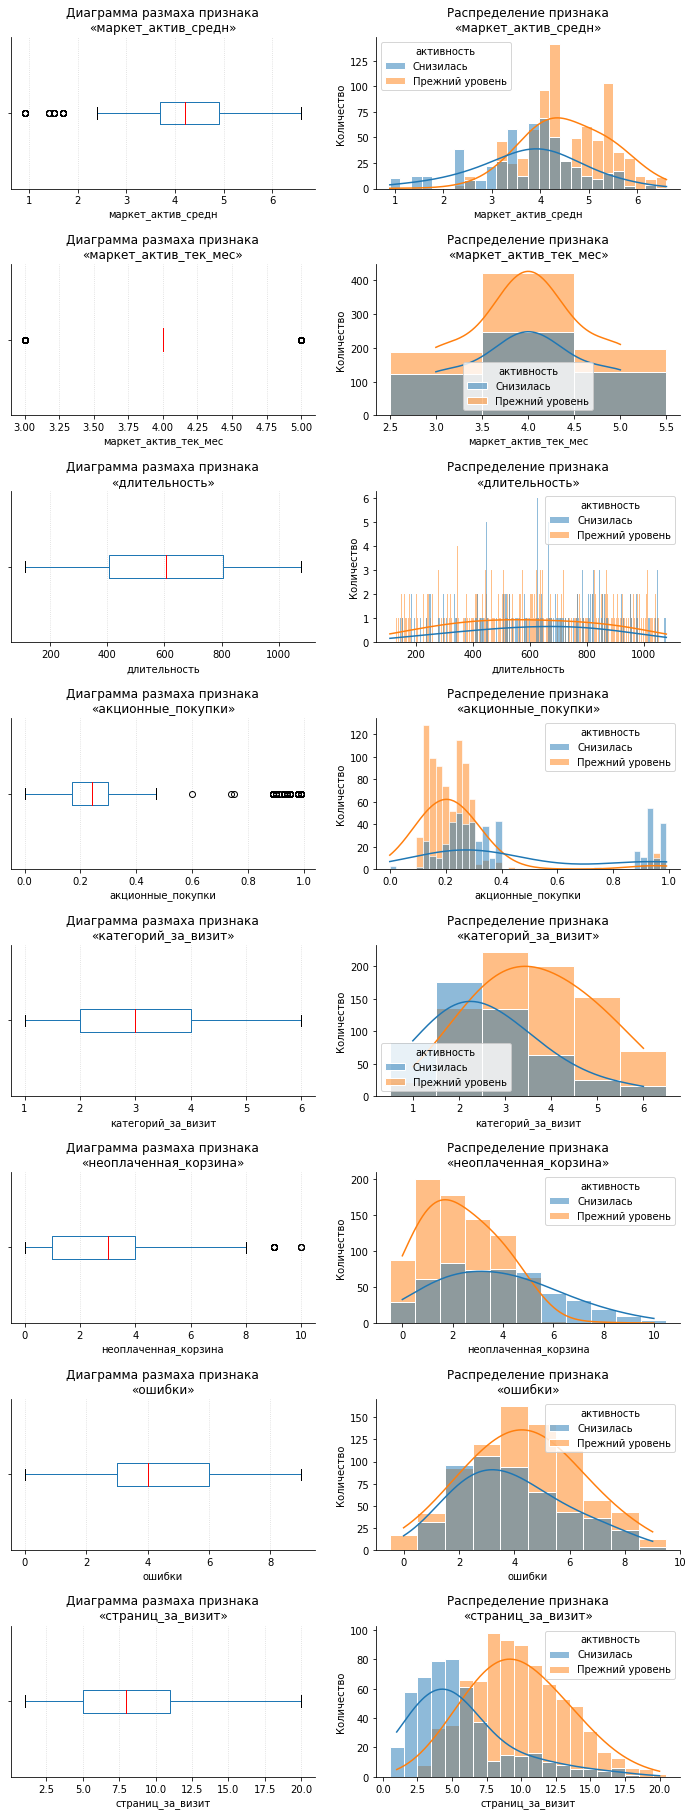

In [ ]:
fig, axes = plt.subplots(len(num_col_names), 2, figsize=(12, 4 * len(num_col_names)))
fig.subplots_adjust(hspace=0.5)
for ind, col_name in enumerate(num_col_names):
    display_box(customers[col_name], axes[ind][0])
    display_hist(customers, col_name, axes[ind][1], hue='активность')
plt.show()

Практически все количественные признаки в датафрейме `customers` имеют распределения, близкие к нормальному (или к распределению Пуассона).

Исключением является признак `акционные_покупки`: мы видим две ярко выраженные группы покупателей — те, кто совершает относительно немного покупок по акциям, и те, у которых доля покупок по акции близка к 100%. Выделим эти две группы пользователей в отдельный столбец `акционные_покупки_группа`.

In [ ]:
customers['акционные_покупки_группа'] = customers['акционные_покупки'].apply(lambda x: 'часто' if x >= 0.5 else 'редко')

Изучим распределения категориальных признаков в датафрейме customers.

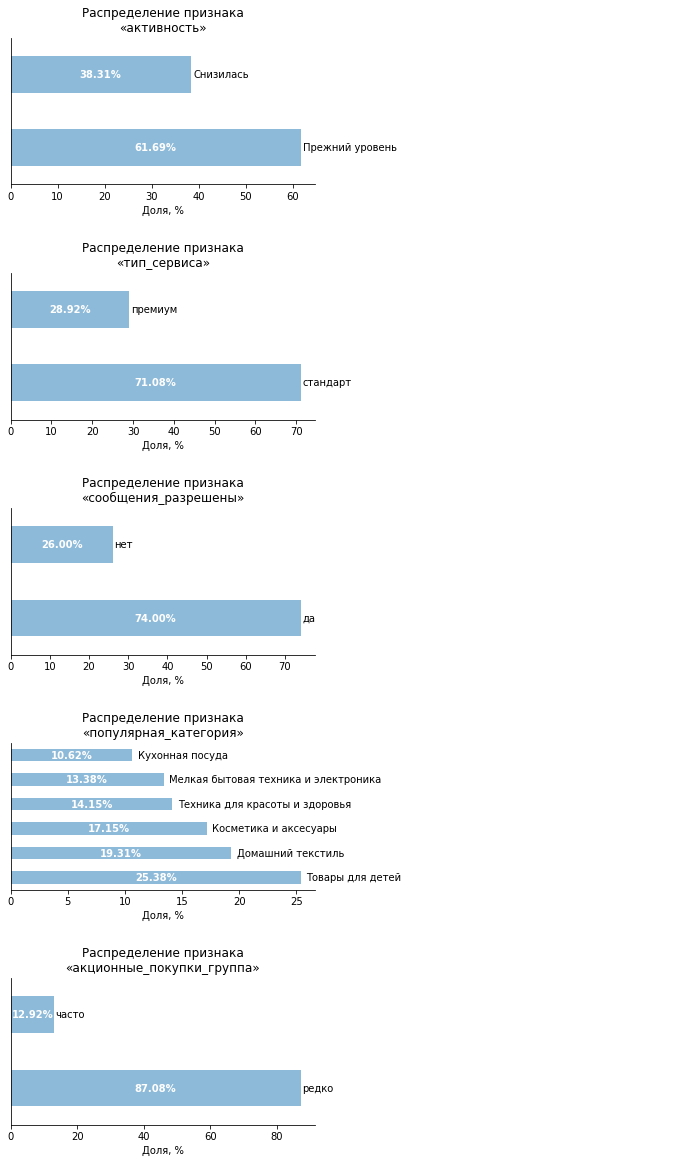

In [ ]:
cat_col_names = customers.select_dtypes(exclude='number').columns

fig, axes = plt.subplots(len(cat_col_names), 2, figsize=(12, 4 * len(cat_col_names)))
fig.subplots_adjust(hspace=0.6)
for ind, col_name in enumerate(cat_col_names):
    display_barh(customers[col_name], axes[ind][0])
    axes[ind][1].set_axis_off()
plt.show()


Необходимо учесть, что мы имеем несбалансированный датасет по целевому признаку активность.

### Покупки

Посмотрим на числовое описание количественных признаков в датафрейме customer_costs.

In [ ]:
customer_costs[['выручка']].describe().T

,count,mean,std,min,25%,50%,75%,max
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


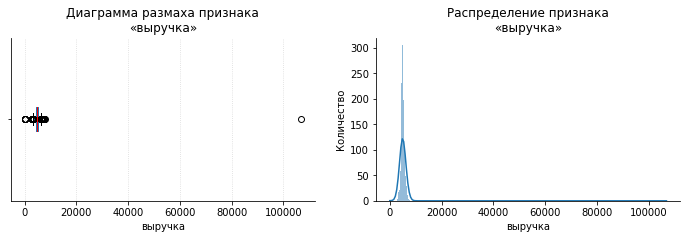

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
display_box(customer_costs['выручка'], ax1)
display_hist(customer_costs, 'выручка', ax2)
plt.show()

На диаграмме размахе заметны выбросы в значениях выручки.

In [ ]:
bad_customer_ids = customer_costs.query('выручка == 0 or выручка == 106862.2')['id'].unique()
len(bad_customer_ids)

4

Выбросы наблюдаются у 4 покупателей. Удалим их.

In [ ]:
customer_costs = customer_costs.drop(customer_costs.query('id in @bad_customer_ids').index, axis=0)

Изучим распределение признака выручка для каждого периода после удаления выбросов.

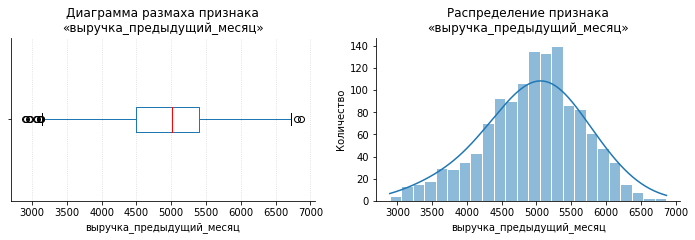

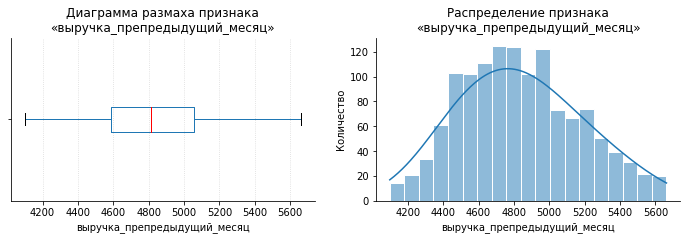

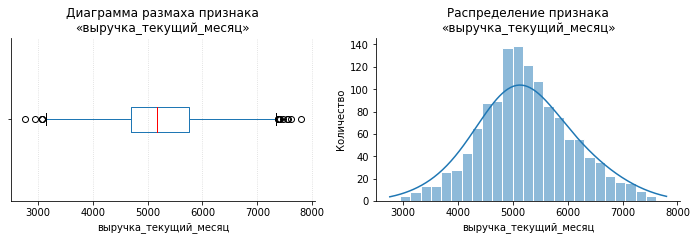

In [ ]:
for key, group in customer_costs.groupby('период'):
    col_name = f'выручка_{key}'
    group = group.rename(columns={'выручка': col_name})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    display_box(group[col_name], ax1)
    display_hist(group, col_name, ax2)
    plt.show()

Признак выручка имеет нормальное распределение.

Изучим распределение признака период.

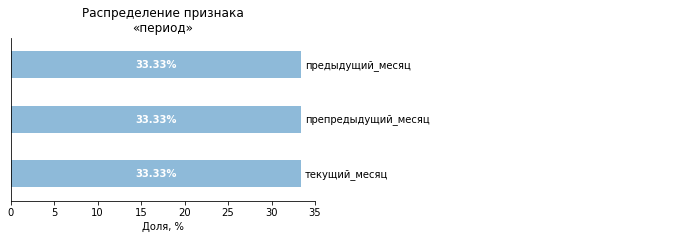

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
display_barh(customer_costs['период'], ax1)
ax2.set_axis_off()
plt.show()

В датафрейме customer_costs содержатся данные о покупках за последние 3 месяца.

### Время на сайте

Посмотрим на числовое описание количественных признаков в датафрейме customer_time.

In [ ]:
customer_time[['время_на_сайте']].describe().T

,count,mean,std,min,25%,50%,75%,max
время_на_сайте,2600.0,13.336154,4.080198,4.0,10.0,13.0,16.0,23.0


Изучим распределение признака время_на_сайте для каждого периода

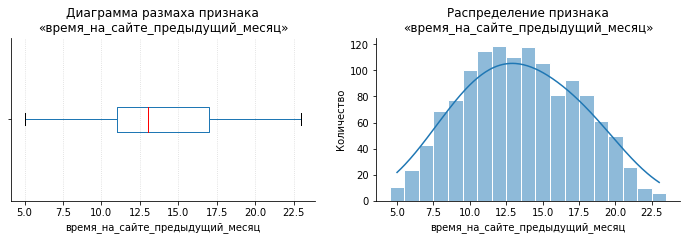

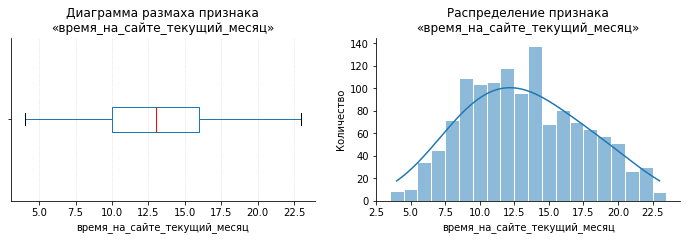

In [ ]:
for key, group in customer_time.groupby('период'):
    col_name = f'время_на_сайте_{key}'
    group = group.rename(columns={'время_на_сайте': col_name})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    display_box(group[col_name], ax1)
    display_hist(group, col_name, ax2)
    plt.show()

Признак время_на_сайте имеет распределение, близкое к нормальному. Выбросов нет.

Изучим распределение признака период.

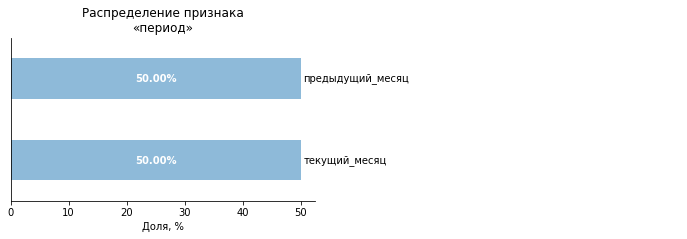

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
display_barh(customer_time['период'], ax1)
ax2.set_axis_off()
plt.show()

В датафрейме customer_costs содержатся данные о времени, проведенном пользователями на сайте, за последние 2 месяца.

### Прибыль

Посмотрим на числовое описание количественных признаков в датафрейме market_profit.

In [ ]:
market_profit[['прибыль']].describe().T

,count,mean,std,min,25%,50%,75%,max
прибыль,1300.0,3.996631,1.013722,0.86,3.3,4.045,4.67,7.43


Изучим распределение признака прибыль.

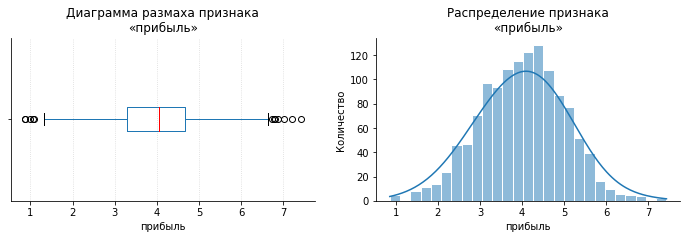

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
display_box(market_profit['прибыль'], ax1)
display_hist(market_profit, 'прибыль', ax2)
plt.show()

Признак прибыль имеет распределение, близкое к нормальному. Есть незначительные выбросы.

По результатам исследовательского анализа данных можно отметить следующее:

- Практически все количественные признаки (за исключением признака акционные_покупки в датафрейме customers) имеют распределения, близкие к нормальному (или к распределению Пуассона).
- У нескольких покупателей обнаружены и удалены выбросы в значениях выручки в датафрейме customer_costs (эти выбросы могут повлиять на качество моделей).
- Обнаружены две ярко выраженные группы покупателей — те, кто совершает относительно немного покупок по акциям, и те, у которых доля покупок по акции близка к 100%. Эти две группы пользователей выделены в отдельный столбец акционные_покупки_группа.
- Мы имеем несбалансированный датасет по целевому признаку активность, следовательно, необходимо стратифицировать данные, чтобы не нарушить соотношение классов в тренировочной и тестовой выборках.

## Объединение таблиц

In [ ]:
customers.shape

(1300, 14)

Добавим в датафрейм с покупателями customers данные о выручке, которую получает магазин с покупателей. Сделаем отдельный столбец для каждого периода.

In [ ]:
grouped = customer_costs.pivot_table(index='id', columns='период')
grouped.columns = 'выручка_' + grouped.columns.droplevel()
grouped.columns = grouped.columns.str.replace('предыдущий_месяц', 'пред_мес')
grouped.columns = grouped.columns.str.replace('текущий_месяц', 'тек_мес')
customers = customers.merge(grouped.reset_index(), on='id', how='inner')
customers.shape

(1296, 17)

Добавим в датафрейм с покупателями customers данные о времени, проведенном пользователями на сайте. Сделаем отдельный столбец для каждого периода.

In [ ]:
grouped = customer_time.pivot_table(index='id', columns='период')
grouped.columns = 'время_на_сайте_' + grouped.columns.droplevel()
grouped.columns = grouped.columns.str.replace('предыдущий_месяц', 'пред_мес')
grouped.columns = grouped.columns.str.replace('текущий_месяц', 'тек_мес')
customers = customers.merge(grouped.reset_index(), on='id', how='left')
customers.shape

(1296, 19)

In [ ]:
customers.isna().sum().sum()

0

Пропусков нет. Посмотрим на результат.

In [ ]:
customers.head()

,id,активность,тип_сервиса,сообщения_разрешены,маркет_актив_средн,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,категорий_за_визит,неоплаченная_корзина,ошибки,страниц_за_визит,акционные_покупки_группа,выручка_пред_мес,выручка_препред_мес,выручка_тек_мес,время_на_сайте_пред_мес,время_на_сайте_тек_мес
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,часто,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,редко,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,часто,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,часто,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,редко,4738.5,5124.0,5388.5,10,10


## Корреляционный анализ

### Матрица корреляций

Поскольку корреляция Пирсона не подходит для категориальных признаков, рассчитаем коэффициенты корреляции Фи между всеми признаками в датафрейме customers. Посмотрим тепловую карту матрицы корреляций.

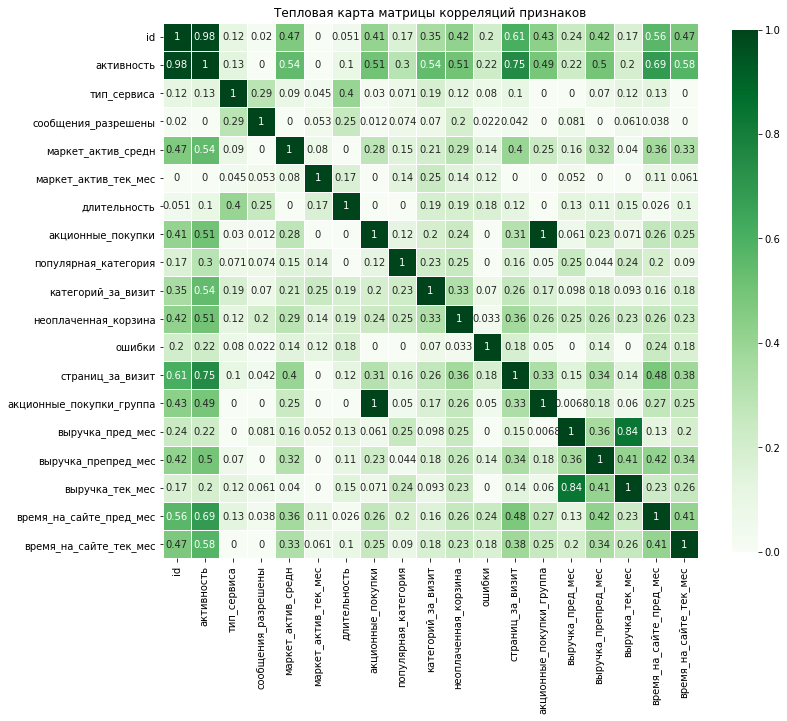

In [ ]:
num_col_names = customers.select_dtypes(include='number').columns
corr_coefficients = customers.phik_matrix(interval_cols=num_col_names)
display_corr_matrix_heatmap(corr_coefficients, 'Тепловая карта матрицы корреляций признаков')

Мультиколлинеарности, которая может негативно повлиять на качество моделей, не наблюдается (за исключением корреляции признаков `акционные_покупки` и `акционные_покупки_группа` — при моделировании не будем использовать их одновременно).

Посмотрим тепловые карты матриц корреляций входных параметров, разбитых по таргету.

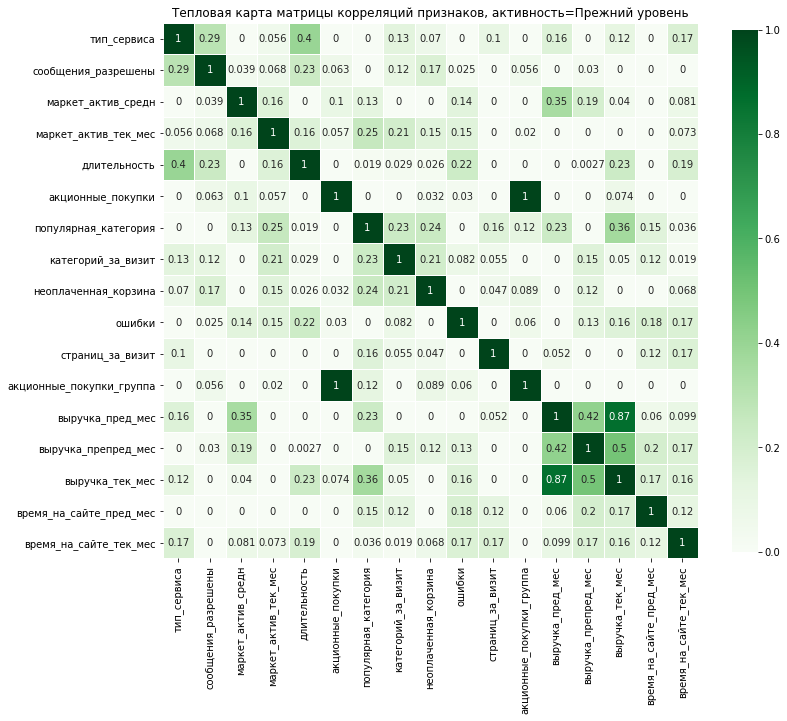

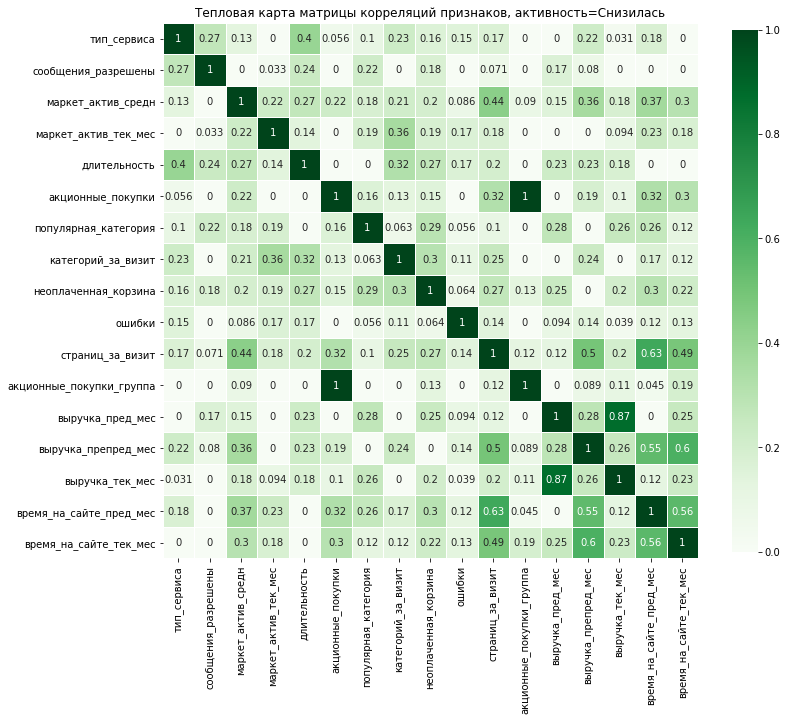

In [ ]:
num_col_names = customers.drop(['id', 'активность'], axis=1).select_dtypes(include='number').columns
for key, group in customers.groupby('активность'):
    corr_coefficients = group.drop(['id', 'активность'], axis=1).phik_matrix(interval_cols=num_col_names)
    display_corr_matrix_heatmap(corr_coefficients,
                                f'Тепловая карта матрицы корреляций признаков, активность={key}')

При сравнении матриц корреляции признаков для данных, разбитых по таргету, можно заметить, что корреляция между признаками начинает проявляться сильнее у группы пользователей, активность которых снизилась.

Добавим новый признак со среднемесячным значением времени, проведенным пользователем на сайте, за последние 2 месяца.

In [ ]:
customers['время_на_сайте_средн'] = (customers['время_на_сайте_пред_мес'] + customers['время_на_сайте_тек_мес']) / 2
phik_value = phik.phik_from_array(customers['время_на_сайте_средн'].values,
                                  customers['активность'].values, num_vars=['x'])
f'{phik_value:.2f}'

'0.77'

Новый признак время_на_сайте_средн обладает высокой корреляцией (0.77) с целевым признаком активность.

Поскольку признаки выручка_тек_мес и выручка_пред_мес обладают высокой корреляцией (0.84), введем новые признаки, характеризующие разницу в выручке от месяца к месяцу. Используем (а может и не используем) новые признаки при моделировании.

In [ ]:
customers['выручка_разн_пред_препред_мес'] = customers['выручка_пред_мес'] - customers['выручка_препред_мес']
customers['выручка_разн_тек_пред_мес'] = customers['выручка_тек_мес'] - customers['выручка_пред_мес']

### Диаграммы рассеяния количественных признаков

Посмотрим на диаграммы рассеяния количественных признаков (с разделением по целевому признаку) в датафрейме `customers`.

In [ ]:
len(customers.query('выручка_разн_тек_пред_мес < -2000'))

1

Выброс в признаке выручка_разн_пред_препред_мес всего один — удаляем.

In [ ]:
customers = customers.drop(customers.query('выручка_разн_тек_пред_мес < -2000').index, axis=0)

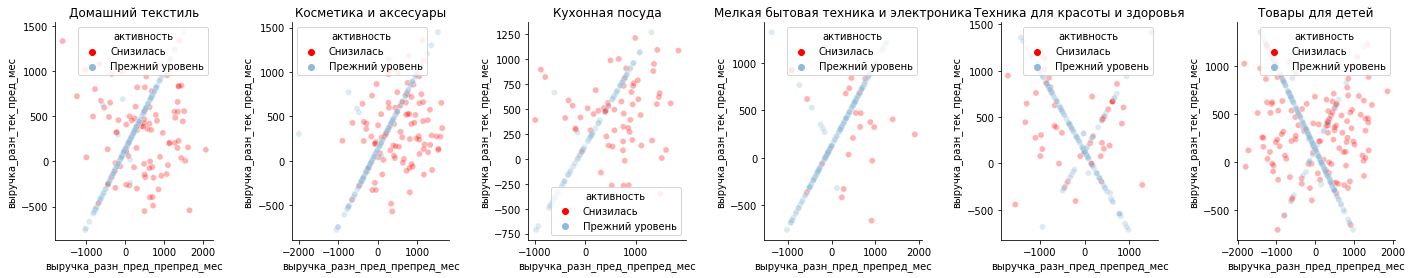

In [ ]:
fig, axes = plt.subplots(1, len(customers['популярная_категория'].unique()), figsize=(24, 4))
plt.subplots_adjust(wspace=0.5)
for ind, (key, group) in enumerate(customers.groupby('популярная_категория')):
    sns.scatterplot(data=group, x='выручка_разн_пред_препред_мес', y='выручка_разн_тек_пред_мес',
                    hue='активность', ax=axes[ind], alpha=0.3, palette=('red', '#8ebad9'))

    axes[ind].set_title(key)
    axes[ind].spines['top'].set_visible(False)
    axes[ind].spines['right'].set_visible(False)
plt.show()

Посмотрим на процент покупателей со снижением активности в различных подгруппах.

In [ ]:
modified = customers.copy()
modified['активность_снизилась'] = modified['активность'] == 'Снизилась'
num_col_names = modified.select_dtypes(exclude='number').columns.drop(['активность', 'активность_снизилась'])
for col_name in num_col_names:
    display(modified
            .pivot_table(index=col_name, values='активность_снизилась', aggfunc=lambda x: f'{x.mean() * 100:.0f}%')
            .reset_index())

,тип_сервиса,активность_снизилась
0,премиум,45%
1,стандарт,35%


,сообщения_разрешены,активность_снизилась
0,да,38%
1,нет,37%


,популярная_категория,активность_снизилась
0,Домашний текстиль,40%
1,Косметика и аксесуары,47%
2,Кухонная посуда,48%
3,Мелкая бытовая техника и электроника,16%
4,Техника для красоты и здоровья,27%
5,Товары для детей,44%


,акционные_покупки_группа,активность_снизилась
0,редко,32%
1,часто,80%


По результатам корреляционного анализа данных можно отметить следующее:

- Мультиколлинеарности, которая может негативно повлиять на качество моделей, не наблюдается.
- Целевой признак активность имеет высокую связь с признаками страниц_за_визит и время_на_сайте_средн, заметную связь с признаками маркет_актив_средн, акционные_покупки, категорий_за_визит, неоплаченная_корзина, выручка_препред_мес, время_на_сайте_пред_мес и время_на_сайте_тек_мес.
- Снижение активности сильнее всего затрагивает пользователей, часто совершающих покупки по акции.
- Снижение активности менее всего затрагивает пользователей, у которых самые популярные категория товаров — «Мелкая бытовая техника и электроника», а также «Техника для красоты и здоровья».

## Использование пайплайнов

Построим модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца — задача сводится к бинарной классификации. Для автоматизации действий по подготовке данных, обучению моделей и оценке их качества будем использовать пайплайны.

При разделении данных на тренировочную и тестовую выборки обязательно выполним стратификацию по целевому признаку `активность`, чтобы не нарушить соотношение классов в тренировочной и тестовой выборках.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    customers.drop('активность', axis=1),
    customers['активность'],
    stratify=customers['активность'],
    test_size=0.25,
    random_state=RANDOM_STATE
)

Для кодирования целевого признака воспользуемся кодировщиком `LabelEncoder`.

In [ ]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Прежний уровень', 'Снизилась'])

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

pd.DataFrame(
    label_encoder.transform(label_encoder.classes_),
    index=label_encoder.classes_,
    columns=['LabelEncoder']
)

,LabelEncoder
Прежний уровень,0
Снизилась,1


Во время подготовки данных используем ColumnTransformer. Для кодирования категориальных признаков используем один из кодировщиков — OneHotEncoder или OrdinalEncoder, для масштабирования количественных признаков используем один из скейлеров — StandardScaler или MinMaxScaler.

Используем четыре модели:

- логистическую регрессию LogisticRegression(),
- метод опорных векторов SVC(),
- метод k-ближайших соседей KNeighborsClassifier(),
- модель дерева решений DecisionTreeClassifier().

Для автоматического подбора гиперпараметров будем использовать инструмент GridSearchCV.

Для оценки качества работы модели вне зависимости от выбранного порога вероятности будем использовать метрику ROC-AUC. Она отлично подходит для бинарной классификации с несбалансированной выборкой — ведь мы имеем несбалансированный датасет по целевому признаку активность.

In [ ]:
cat_col_names = ['тип_сервиса', 'сообщения_разрешены', 'популярная_категория']
num_col_names = ['маркет_актив_средн', 'маркет_актив_тек_мес', 'длительность',
                 'время_на_сайте_средн', 'время_на_сайте_тек_мес', 'страниц_за_визит',
                 'ошибки', 'категорий_за_визит', 'неоплаченная_корзина',
                 'акционные_покупки', 'выручка_препред_мес', 'выручка_пред_мес',
                 'выручка_тек_мес']
used_col_names_in_model = cat_col_names + num_col_names

ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False, drop = 'first'))
])

ord_pipe = Pipeline([
    ('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer(
    [
        ('cat', ohe_pipe, cat_col_names),
        ('num', MinMaxScaler(), num_col_names)
    ],
    remainder='drop'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'preprocessor__cat': [ohe_pipe, ord_pipe],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 6)
    },
    {
        'preprocessor__cat': [ohe_pipe, ord_pipe],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10)
    },
    {
        'preprocessor__cat': [ohe_pipe, ord_pipe],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(1, 6)
    }
]

start = time.time()

search_cv = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
search_cv.fit(X_train, y_train)

display(f'На подбор гиперпараметров затрачено времени: {time.time() - start:.0f} сек')
display(f'Метрика ROC-AUC при кросс-валидации: {search_cv.best_score_:.4f}')

'На подбор гиперпараметров затрачено времени: 67 сек'

'Метрика ROC-AUC при кросс-валидации: 0.9203'

Посмотрим на результаты лучших моделей каждого типа.

In [ ]:
results_columns = {
    'model': 'Модель',
    'rank_test_score': 'Ранг',
    'mean_test_score': 'ROC-AUC при кросс-валидации',
    'params': 'Параметры',
    'mean_fit_time': 'Время обучения',
    'mean_score_time': 'Время предсказания'
}

results = pd.DataFrame(search_cv.cv_results_)
results['model'] = results['param_models'].apply(lambda x: x.__class__.__name__)
for column in ['mean_test_score', 'mean_fit_time', 'mean_score_time']:
    results[column] = np.round(results[column], 2)

results = (
    results
    .sort_values(by='rank_test_score')
    .pivot_table(index='model', aggfunc='first')
    .sort_values(by='rank_test_score')
    .reset_index()[results_columns.keys()]
    .rename(columns=results_columns)
)
results

,Модель,Ранг,ROC-AUC при кросс-валидации,Параметры,Время обучения,Время предсказания
0,SVC,1,0.92,"{'models': SVC(C=2, probability=True, random_s...",0.11,0.01
1,KNeighborsClassifier,4,0.92,"{'models': KNeighborsClassifier(), 'models__n_...",0.01,0.01
2,LogisticRegression,41,0.91,"{'models': LogisticRegression(penalty='l1', ra...",0.02,0.01
3,DecisionTreeClassifier,73,0.89,{'models': DecisionTreeClassifier(random_state...,0.02,0.01


Лучше всего показал себя метод опорных векторов SVC() с гиперпараметром C=1, кодированием OneHotEncoder() и масштабированием StandardScaler(). Посмотрим на результаты лучшей модели на тестовой выборке.

In [ ]:
y_test_predict_proba = search_cv.predict_proba(X_test)[:, 1]
display(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_predict_proba):.4f}')

'Метрика ROC-AUC на тестовой выборке: 0.9111'

Модель хорошо описывает тренировочные данные (ROC-AUC ~0.92 при кросс-валидации), её предсказательные свойства высоки (ROC-AUC ~0.91 на тестовой выборке). Следовательно, нет оснований говорить о переобучении или недообучении модели.

## Анализ важности признаков

### Перестановочная важность

Оценим важность признаков для лучшей модели. Для начала используем самый простой показатель — permutation importance.

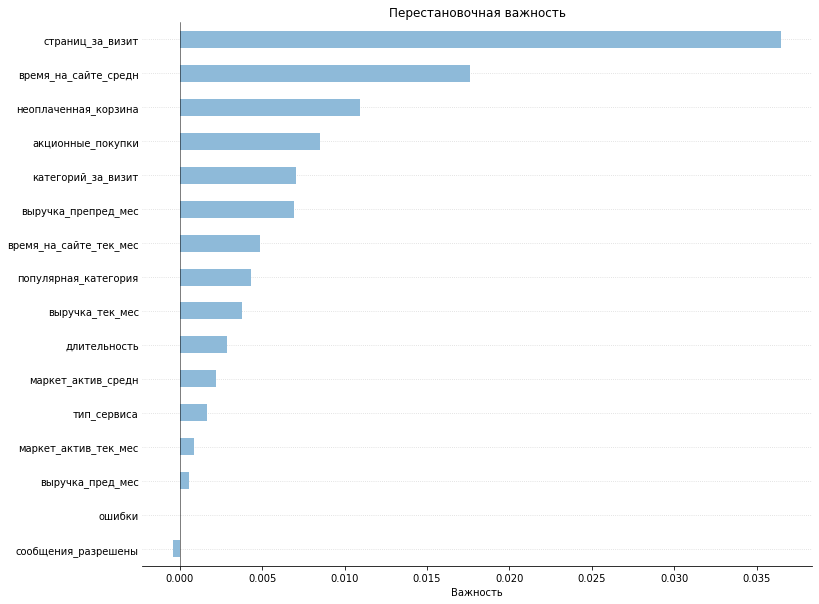

In [ ]:
permutation = permutation_importance(search_cv, X_test[used_col_names_in_model], y_test,
                                     scoring='roc_auc', random_state=RANDOM_STATE)

feature_importances = pd.DataFrame({
    'признак': used_col_names_in_model,
    'важность': permutation['importances_mean']
}).sort_values('важность', ascending=True)

ax = feature_importances.plot(x='признак', y='важность', kind='barh',
                              figsize=(12, 10), legend=False, color='#8ebad9')
ax.set_title('Перестановочная важность')
ax.set_xlabel('Важность')
ax.set_ylabel('')
ax.set_axisbelow(True)
ax.tick_params(axis='y', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', alpha=0.5, linestyle=':')
ax.axvline(x=0, linewidth=0.5, color='black')
ax.axvline(x=-0.002, linewidth=0.5, color='white');

### SHAP

Оценим важность признаков для лучшей модели и построим графики важности с помощью метода SHAP.

In [ ]:
prepared_col_names = search_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
prepared_X_train = search_cv.best_estimator_.named_steps['preprocessor'].transform(X_train)
prepared_X_test = search_cv.best_estimator_.named_steps['preprocessor'].transform(X_test)

explainer = shap.KernelExplainer(
    search_cv.best_estimator_.named_steps['models'].predict,
    shap.kmeans(prepared_X_train, 20),
    prepared_col_names
)

shap_values = explainer(shap.sample(prepared_X_test, 100, random_state=RANDOM_STATE))

  0%|          | 0/100 [00:00<?, ?it/s]

Для визуализации вклада признаков в каждое предсказание модели используем диаграмму shap.plots.violin. На оси X отложены значения Шепли, на оси Y — признаки модели, расположенные сверху вниз в порядке убывания средних SHAP‑значений.

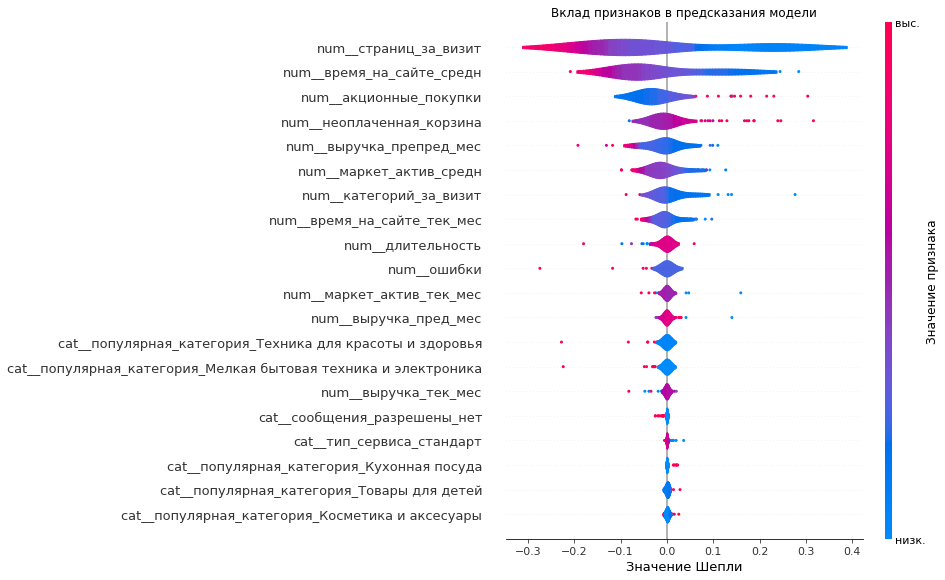

In [ ]:
shap.plots.violin(shap_values, max_display=len(prepared_col_names), show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title('Вклад признаков в предсказания модели')
ax.set_xlabel('Значение Шепли')
fig.axes[-1].set_ylabel('Значение признака')
fig.axes[-1].set_yticklabels(['низк.', 'выс.'])
plt.show()

Для оценки общего вклада признаков в прогнозы модели используем диаграмму shap.plots.bar.

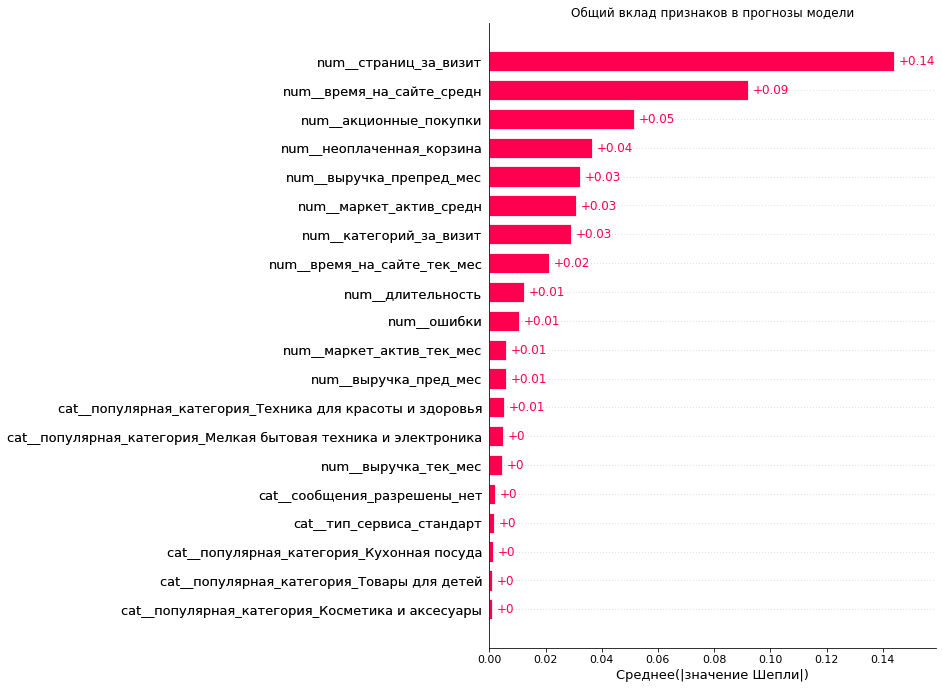

In [ ]:
shap.plots.bar(shap_values, max_display=len(prepared_col_names), show=False)
ax = plt.gca()
ax.set_title('Общий вклад признаков в прогнозы модели')
ax.set_xlabel('Среднее(|значение Шепли|)')
plt.show()

Оценка важности признаков как с помощью метода «перестановочной важность», так и с помощью вычислений значений Шепли показывают схожие результаты в признаках, которые сильнее всего влияют на классификацию:

- страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца,
- время_на_сайте_средн — среднемесячное значение времени, проведенного пользователем на сайте, за последние 2 месяца,
- акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев,
- неоплаченная_корзина — общее число неоплаченных товаров в корзине за последние 3 месяца,
- категорий_за_визит — показатель того, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

Оценка важности признаков c помощью метода SHAP показывает, что для модели мало значимы признаки:

- популярная категория — самая популярная категория товаров у покупателя за последние 6 месяцев,
- тип_сервиса — уровень сервиса,
- сообщения разрешены — информация о том, можно ли присылать покупателю дополнительные предложения о товаре.

Исходя из анализа важности признаков можно сделать несколько выводов, которые могут быть полезны при принятии бизнес-решений:

- Чем больше покупатель взаимодействует с сайтом (проводит больше времени и просматривает больше товаров в различных категориях), тем меньше вероятность снижения покупательской активности.
- Чем больше покупатель приобретает товаров по акции, тем больше вероятность снижения покупательской активности.

Выводы по результатам анализа важности признаков


Оценка важности признаков с помощью методов перестановочной важности и SHAP показала, что наибольшее влияние на предсказание модели оказывают поведенческие метрики, связанные с вовлеченностью пользователей.


Ключевые факторы, влияющие на удержание клиентов:


- Высокая вовлеченность снижает риск оттока. Признаки страниц_за_визит, время_на_сайте_средн и категорий_за_визит оказались наиболее важными. Как было показано на этапе EDA и подтверждено SHAP-анализом, чем больше времени пользователь проводит на сайте и чем глубже изучает ассортимент, тем ниже вероятность снижения его покупательской активности. Это говорит о том, что активное взаимодействие с платформой является главным индикатором лояльности.

- "Охотники за скидками" — сегмент риска. Особого внимания заслуживает признак акционные_покупки. SHAP-анализ показал, что чем выше доля акционных покупок у клиента, тем выше модель оценивает вероятность его ухода. Это может свидетельствовать о наличии сегмента "охотников за скидками", которые не проявляют лояльности к бренду и активны только в периоды распродаж. Между акциями их активность падает, что и фиксирует модель.

- Брошенные корзины — четкий сигнал к уходу. Признак неоплаченная_корзина также вошел в топ-5. Рост числа брошенных товаров является сильным предиктором будущего снижения активности, что интуитивно понятно и подтверждается моделью.


Малозначимые признаки:


- Модель присвоила низкую важность таким признакам, как популярная категория, тип_сервиса и сообщения разрешены. Это означает, что для прогнозирования оттока не так важно, что именно покупает клиент или какой у него уровень сервиса, как то, как он себя ведет на сайте.


Бизнес-рекомендации:


- Фокусироваться на вовлечении: Усилия по удержанию стоит направить на повышение времени сессий и глубины просмотра сайта. Можно внедрять геймификацию, персональные рекомендации, интересный контент.
- Работать с брошенными корзинами: Активно использовать триггерные рассылки и push-уведомления для возвращения пользователей к неоплаченным товарам.

## Сегментация покупателей

In [ ]:
customers.shape

(1295, 22)

Добавим в датафрейм с покупателями customers данные о среднемесячной прибыли покупателя за последние 3 месяца.

In [ ]:
customers = customers.merge(market_profit, on='id', how='inner')
customers.shape

(1295, 23)

Добавим новый столбец с отношением прибыли к выручке, которую получает магазин с покупателя.

In [ ]:
customers['рентабельность'] = customers['прибыль'] / (customers['выручка_препред_мес'] +
                                                      customers['выручка_пред_мес'] +
                                                      customers['выручка_тек_мес'])

In [ ]:
customers.isna().sum().sum()

0

Пропусков нет. Посмотрим на результат.

In [ ]:
customers.head()

,id,активность,тип_сервиса,сообщения_разрешены,маркет_актив_средн,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,категорий_за_визит,...,выручка_пред_мес,выручка_препред_мес,выручка_тек_мес,время_на_сайте_пред_мес,время_на_сайте_тек_мес,время_на_сайте_средн,выручка_разн_пред_препред_мес,выручка_разн_тек_пред_мес,прибыль,рентабельность
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,5216.0,4472.0,4971.6,12,10,11.0,744.0,-244.4,4.16,0.000284
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,5457.5,4826.0,5058.4,8,13,10.5,631.5,-399.1,3.13,0.000204
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6158.0,4793.0,6610.4,11,13,12.0,1365.0,452.4,4.87,0.000277
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,5807.5,4594.0,5872.5,8,11,9.5,1213.5,65.0,4.21,0.000259
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,4738.5,5124.0,5388.5,10,10,10.0,-385.5,650.0,3.95,0.000259


Построим тепловую карту рентабельности продаж интернет-магазина для различных сегментов покупателей.

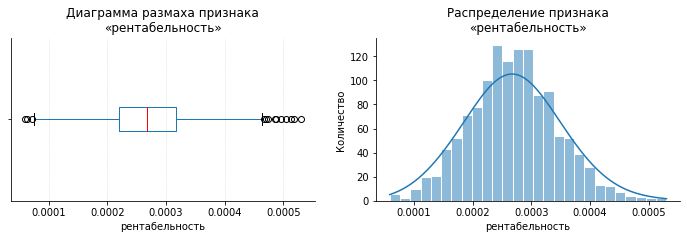

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
display_box(customers['рентабельность'], ax1)
display_hist(customers, 'рентабельность', ax2)
plt.show()

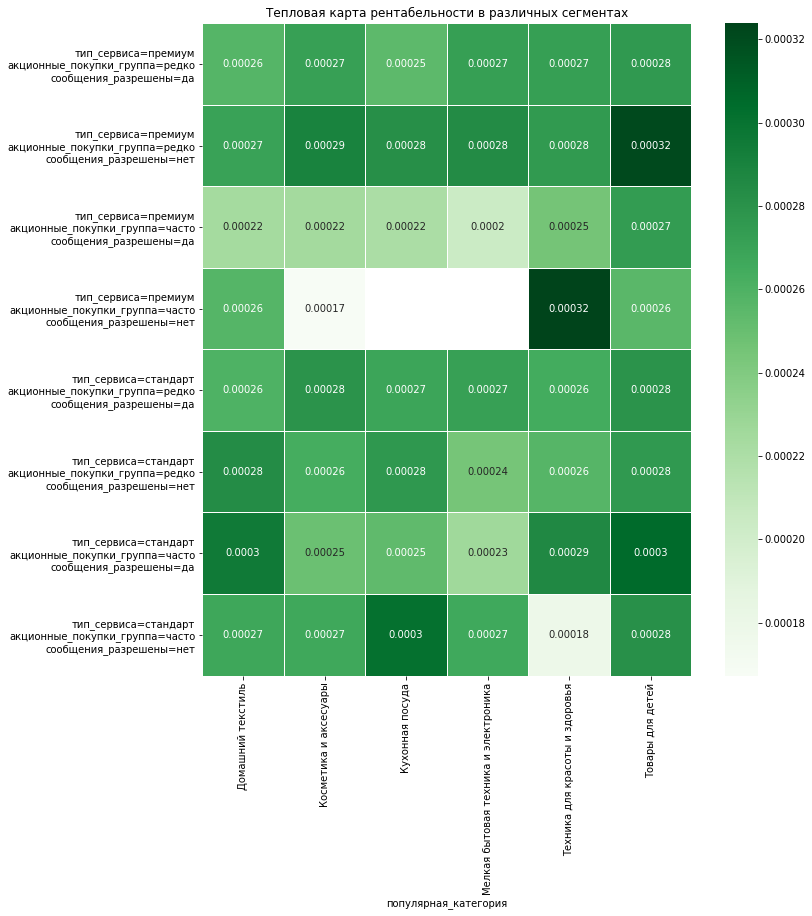

In [ ]:
def replace_yticklabel(text, features):
    return '\n'.join(f'{features[ind]}={value}' for ind, value in enumerate(text.split('-')))


features = ['тип_сервиса', 'акционные_покупки_группа', 'сообщения_разрешены']
segments = customers.pivot_table(index=features, columns='популярная_категория', values='рентабельность')

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(segments, annot=True, square=True, cbar=True, cbar_kws={'shrink': 1},
            linewidths=0.5, cmap='Greens', ax=ax)
ax.set_title('Тепловая карта рентабельности в различных сегментах')
ax.set_ylabel('')
ax.set_yticklabels([replace_yticklabel(label.get_text(), features) for label in ax.get_yticklabels()])
plt.show()

Мы видим, что наиболее рентабельными являются клиенты премиум-сервиса, которые редко покупают товары по акции и отказываются от получения маркетинговых сообщений.

Возьмем для примера сегмент клиентов премиум-сервиса, которые редко покупают товары по акции, но при этом согласны на получение маркетинговых сообщений. Посмотрим, как в этом сегменте отличаются клиенты со снижением покупательской активности и с прежним уровнем активности.

In [ ]:
segment = customers.query('тип_сервиса == "премиум" and \
                           акционные_покупки_группа == "редко" and \
                           сообщения_разрешены == "да"')

pd.DataFrame({
    'Снижение активности': segment.query('активность == "Снизилась"').describe().T['mean'],
    'Прежний уровень активности': segment.query('активность != "Снизилась"').describe().T['mean']
}).drop('id')

,Снижение активности,Прежний уровень активности
маркет_актив_средн,3.675238,4.527119
маркет_актив_тек_мес,3.942857,3.926554
длительность,750.333333,733.429379
акционные_покупки,0.277524,0.209209
категорий_за_визит,2.495238,3.451977
неоплаченная_корзина,3.352381,2.519774
ошибки,4.028571,4.344633
страниц_за_визит,5.866667,10.683616
выручка_пред_мес,5093.342857,4960.593220
выручка_препред_мес,4707.552381,4920.757062


In [ ]:
all_customers_features = customers[used_col_names_in_model]
customers['churn_probability'] = search_cv.best_estimator_.predict_proba(all_customers_features)[:, 1]

In [ ]:
display(customers[['id', 'churn_probability', 'рентабельность']].head())

,id,churn_probability,рентабельность
0,215349,0.990158,0.000284
1,215350,0.373833,0.000204
2,215351,0.884355,0.000277
3,215352,0.960144,0.000259
4,215353,0.836212,0.000259


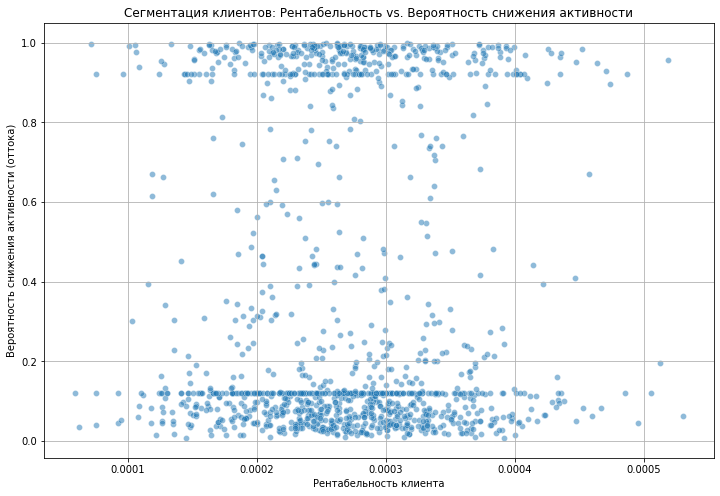

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=customers, x='рентабельность', y='churn_probability', alpha=0.5)
plt.title('Сегментация клиентов: Рентабельность vs. Вероятность снижения активности')
plt.xlabel('Рентабельность клиента')
plt.ylabel('Вероятность снижения активности (оттока)')
plt.grid(True)
plt.show()

In [ ]:
profitability_threshold = customers['рентабельность'].quantile(0.75)
churn_threshold = 0.6


target_segment = customers.query(
    'рентабельность > @profitability_threshold and churn_probability > @churn_threshold'
)
print(f"Найдено {len(target_segment)} клиентов в целевом сегменте.")

Найдено 111 клиентов в целевом сегменте.


Для анализа был выбран сегмент "Высокорентабельные клиенты под угрозой", так как их удержание принесет максимальную пользу для бизнеса.

Мы видим, что у клиентов со снижением покупательской активности в корзине больше неоплаченных товаров, чем у клиентов с прежним уровнем активности. Поскольку покупатели в данном сегменте согласны на получение маркетинговых сообщений, интернет-магазин «В один клик» может разослать сообщения с напоминанием о том, что в корзине остались неоплаченные товары.

В качестве общих рекомендаций по увеличению покупательской активности можно посоветовать следующие шаги:

- Для улучшение поведенческих факторов на сайте и в приложении добавить блоки «С этим товаром покупают», «Ещё может подойти» и подобные им. Чем больше товаров просмотрит покупать, тем больше вероятность, что он найдет товары, которые его заинтересуют и которые он захочет купить.
- Покупателям, которые согласны на получение сообщений, и у которых в корзине накапливается много неоплаченных товаров, отправлять напоминания о товарах в корзине.
- «Рентабельным» покупателям, которые часто покупают товары по акциям (например, сегмент «тип сервиса = стандарт, лююимая категория = товары для детей»), делать персональные подборки акционных предложений.

## Итоговые выводы

В ходе исследования обработаны и проанализированы данные о ~1300 клиентах интернет-магазина «В один клик», их поведении на сайте, продуктовом поведении, выручке и прибыли с каждого клиента. Построена модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

В результате **предобработки данных**:
- Скорректированы названия столбцов в датафреймах.
- Явных дубликатов и пропусков в данных не обнаружено.
- Исправлены опечатки в значениях нескольких столбцов.

По результатам **исследовательского анализа данных** можно отметить следующее:
- Практически все количественные признаки (за исключением признака `акционные_покупки` в датафрейме `customers`) имеют распределения, близкие к нормальному (или к распределению Пуассона).
- У нескольких покупателей обнаружены и удалены выбросы в значениях выручки в датафрейме `customer_costs` (эти выбросы могут повлиять на качество моделей).
- Обнаружены две ярко выраженные группы покупателей — те, кто совершает относительно немного покупок по акциям, и те, у которых доля покупок по акции близка к 100%. Эти две группы пользователей выделены в отдельный столбец `акционные_покупки_группа`.
- Мы имеем несбалансированный датасет по целевому признаку `активность`, следовательно, необходимо стратифицировать данные, чтобы не нарушить соотношение классов в тренировочной и тестовой выборках.

По результатам **корреляционного анализа данных** можно отметить следующее:
- Мультиколлинеарности, которая может негативно повлиять на качество моделей, не наблюдается.
- Целевой признак `активность` имеет высокую связь с признаками `страниц_за_визит` и `время_на_сайте_средн`, заметную связь с признаками `маркет_актив_средн`, `акционные_покупки`, `категорий_за_визит`, `неоплаченная_корзина`, `выручка_препред_мес`, `время_на_сайте_пред_мес` и `время_на_сайте_тек_мес`.
- Снижение активности сильнее всего затрагивает пользователей, часто совершающих покупки по акции.
- Снижение активности менее всего затрагивает пользователей, у которых самые популярные категория товаров — «Мелкая бытовая техника и электроника», а также «Техника для красоты и здоровья».

**Построена модель**, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца (задача сводится к бинарной классификации). Для автоматизации действий по подготовке данных, обучению моделей и оценке их качества были использованы пайплайны и автоматический подбор гиперпараметров. Лучше всего показал себя метод опорных векторов.

**Оценка важности признаков** позволила сделать несколько выводов, которые могут быть полезны при принятии бизнес-решений:
- Чем больше покупатель взаимодействует с сайтом (проводит больше времени и просматривает больше товаров в различных категориях), тем меньше вероятность снижения покупательской активности.
- Чем больше покупатель приобретает товаров по акции, тем меньше вероятность снижения покупательской активности.

В качестве общих **рекомендаций по увеличению покупательской активности** можно посоветовать следующие шаги:
- Для улучшение поведенческих факторов на сайте и в приложении добавить блоки «С этим товаром покупают», «Ещё может подойти» и подобные им. Чем больше товаров просмотрит покупать, тем больше вероятность, что он найдет товары, которые его заинтересуют и которые он захочет купить.
- Покупателям, которые согласны на получение сообщений, и у которых в корзине накапливается много неоплаченных товаров, отправлять напоминания о товарах в корзине.
- «Рентабельным» покупателям, которые часто покупают товары по акциям (например, сегмент «тип сервиса = стандарт, лююимая категория = товары для детей»), делать персональные подборки акционных предложений.